2022-03-31 Ludovico Massaccesi

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.special import factorial

# Frequentist interval estimation
Take a Poisson and compute the lower, upper, and central limits for $n=0,\dots,10$.

In [2]:
# Define the Poisson PMF and CDF

def pmf(n, mu):
    """Poisson PMF."""
    return np.exp(-mu) * mu**n / factorial(n)

def cdf(nmin, nmax, mu):
    """Computes the sum of pmf(n,mu) for n in [nmin,nmax]."""
    return np.sum(pmf(np.arange(nmin, nmax+1), mu))

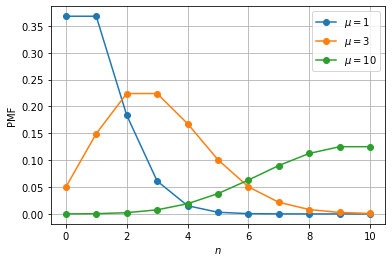

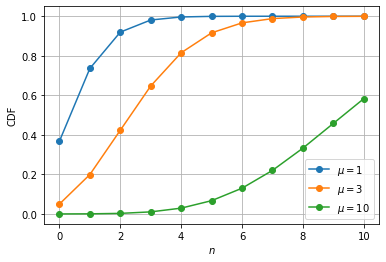

In [3]:
# Check that I wrote them correctly
n = np.arange(11)

plt.figure()
for mu in [1, 3, 10]:
    plt.plot(n, pmf(n, mu), 'o-', label=fr"$\mu={mu:g}$")
plt.grid()
plt.legend()
plt.xlabel("$n$")
plt.ylabel("PMF")
plt.show()

plt.figure()
for mu in [1, 3, 10]:
    plt.plot(n, [cdf(0, i, mu) for i in n], 'o-', label=fr"$\mu={mu:g}$")
plt.grid()
plt.legend()
plt.xlabel("$n$")
plt.ylabel("CDF")
plt.show()

Neyman's bands are defined by requiring that
$$C(\mu)=\sum_{n:o(n)<c}p(n;\mu)\geq CL$$
and solving for $c$, for each value of $\mu$.
The ordering function $o(n)$ is defined by:

1. $o(n)=n$ (sort by $n$ ascending) for the lower limit;
2. $o(n)=-n$ (sort by $n$ descending) for the upper limit;
3. $o(n)=|C(n;\mu)-\frac{1}{2}|$ (sort by distance from the point with cumulant $1/2$ ascending) for the central limit;
4. $o(n)=-P(n;\mu)$ (sort by PMF descending) for the P-ordering limit.

Applying this metod directly requires repeating the procedure for a large number of values of $\mu$ in order to obtain high precision limits.
However, this rapidly becomes very computationally expensive as the required precision increases.

Since, in a real case, $n$ will be fixed by the observation (and, in this exercise, $n$ takes only a limited number of values), one might try to reverse the problem by fixing the last $n$ that will be included in the band (in the order given by $o$), and solve $C(\mu)=CL$ for $\mu$ numerically.

In [4]:
def find_root(f, x1, x2, precision=1e-7):
    """Finds x such that f(x) == 0 within precision,
    using the bisection method in the interval [x1,x2]."""
    if f(x1) == 0 or f(x2) == 0:
        print("INFO One of the extrema is a root.")
        return x1 if f(x1) == 0 else x2
    if f(x1) * f(x2) > 0:
        print("ERROR The function has the same sign at the extrema.")
        print(f"    f({x1}) = {f(x1)}")
        print(f"    f({x2}) = {f(x2)}")
        return np.nan
    while x2-x1 > precision:
        x = (x1 + x2) / 2
        fc = f(x)
        if fc == 0:
            break  # Root found
        if f(x1) * fc < 0:
            x2 = x
        else:
            x1 = x
    return x

In [5]:
n_values = list(range(11))
cl = 0.95

In [6]:
%%time
# Lower limit
lower_limits = []
for n in n_values:
    # No need to sort before doing the sum here
    mu_min = find_root(lambda mu: cdf(0, n, mu) - cl, 0, 5*(n+1))
    lower_limits.append(mu_min)

CPU times: user 24.6 ms, sys: 32 µs, total: 24.6 ms
Wall time: 23.4 ms


In [7]:
%%time
# Upper limit
upper_limits = []
for n in n_values:
    # Since the sorting is descending from +∞, so I use
    # 1-SUM_FROM_0_TO_n == CL instead
    # Again, no need to sort
    mu_max = find_root(lambda mu: 1 - cdf(0, n, mu) - cl, n, 5*(n+1))
    upper_limits.append(mu_max)

CPU times: user 24.3 ms, sys: 3.39 ms, total: 27.7 ms
Wall time: 25 ms


In [8]:
%%time
# Central limits
central_limits = []
for n in n_values:
    # Here I can find the two limits of the interval
    # separately using SUM_FROM_0_TO_n == (1-CL)/2
    # and 1-SUM_FROM_0_TO_n == (1-CL/2)
    rhs = (1-cl)/2
    mu_max = find_root(lambda mu: cdf(0, n, mu) - rhs, 0, 5*(n+1))
    mu_min = find_root(lambda mu: 1 - cdf(0, n, mu) - rhs, 0, 5*(n+1))
    central_limits.append((mu_min, mu_max))

CPU times: user 29.5 ms, sys: 0 ns, total: 29.5 ms
Wall time: 29 ms


In [9]:
%%time
# P-ordering limits

# This time I need to sort the n before summing
N_TO_SORT = list(range(100))
def p_ordered_sum(mu, n_min=0, n_max=np.inf):
    """Computes the sum of p(n;μ) for all the n values,
    sorted by p(n;μ) descending, until a value smaller
    than n_min or larger than n_max is found."""
    N_TO_SORT.sort(key=lambda n: -pmf(n, mu))  # Uses timsort
    s = 0.0
    for n in N_TO_SORT:
        if n < n_min or n > n_max:
            break
        s += pmf(n, mu)
    return s

p_limits = []
for n in n_values:
    mu_min = find_root(lambda mu: p_ordered_sum(mu, n_max=n) - cl, 0, 5*(n+1))
    mu_max = find_root(lambda mu: p_ordered_sum(mu, n_min=n) - cl, 0, 5*(n+1))
    p_limits.append((mu_min, mu_max))

ERROR The function has the same sign at the extrema.
    f(0) = 0.050000000000000044
    f(5) = 0.050000000000000044
CPU times: user 492 ms, sys: 3.46 ms, total: 495 ms
Wall time: 494 ms


In [10]:
print(" N     lower       upper           central               p-ordering     ")
print("------------------------------------------------------------------------")
for n, l, u, (c1, c2), (p1, p2) in zip(n_values, lower_limits, upper_limits,
                                       central_limits, p_limits):
    print(f"{n:2d}  {l:10.7f}  {u:10.7f}  {c1:10.7f} {c2:10.7f}  {p1:10.7f} {p2:10.7f}")

 N     lower       upper           central               p-ordering     
------------------------------------------------------------------------
 0   0.0512933   2.9957322   0.0253177  3.6888794   0.0512933        nan
 1   0.3553615   4.7438646   0.2422092  5.5716433   0.3553615  3.7643506
 2   0.8176915   6.2957937   0.6186721  7.2246876   0.8176915  5.7559309
 3   1.3663184   7.7536566   1.0898653  8.7672731   1.3663184  7.2949573
 4   1.9701495   9.1535191   1.6234864 10.2415887   1.9701495  8.8076969
 5   2.6130148  10.5130349   2.2018943 11.6683321   2.6130148 10.3072513
 6   3.2853157  11.8423957   2.8143631 13.0594740   3.2853157 11.7991564
 7   3.9808228  13.1481138   3.4538322 14.4226753   3.7643506 13.2861992
 8   4.6952276  14.4346496   4.1153731 15.7631892   4.4601430 14.3402175
 9   5.4254058  15.7052164   4.7953888 17.0848035   5.3233211 15.8197301
10   6.1690072  16.9622192   5.4911603 18.3903560   5.7559309 17.2978262


In [11]:
from scipy.interpolate import interp1d
def my_plot(n, l=0.0, u=np.inf, coverage=None, title=""):
    fig, ax = plt.subplots()
    mus = set()
    xmin, xmax = np.inf, 0
    if not isinstance(l, float):
        plt.scatter(l, n, c='tab:blue')
        xmin, xmax = np.min(l), np.max(l)
        mus |= set(l)
    if not isinstance(u, float):
        plt.scatter(u, n, c='tab:blue')
        xmin, xmax = min(np.min(u), xmin), max(np.max(u), xmax)
        mus |= set(u)
    mus = list(mus)
    mus.sort()
    xlim = (xmin, xmax)  # plt.xlim()
    plt.fill_betweenx(n, xlim[0] if isinstance(l, float) else l,
                      xlim[1] if isinstance(u, float) else u,
                      color='tab:blue', alpha=0.5)
    plt.xlabel(r"$\mu$")
    plt.ylabel(r"$n$", color='tab:blue')
    plt.ylim(0, 10)
    plt.xlim(*xlim)
    plt.title(title)
    ax.tick_params(axis='y', labelcolor='tab:blue', color='tab:blue')

    if isinstance(u, float):
        nmin = np.zeros(len(mus), dtype=int)
    else:
        nmin = np.round(np.interp(mus, u, n)).astype(int)
    if isinstance(l, float):
        coverage = [1 - cdf(0, n, mu) for n, mu in zip(nmin, mus)]
    else:
        nmax = np.round(interp1d(l, n, fill_value="extrapolate")(mus)).astype(int)
        coverage = [cdf(n1, n2, mu) for n1, n2, mu in zip(nmin, nmax, mus)]
    
    ax2 = plt.twinx()
    ax2.plot(mus, coverage, '.-', c='tab:red')
    ax2.set_ylim(0.93, 0.97)
    ax2.yaxis.set_major_locator(mticker.MultipleLocator(0.01))
    ax2.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.0%}"))
    ax2.set_ylabel("Coverage", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red', color='tab:red')
    plt.show()

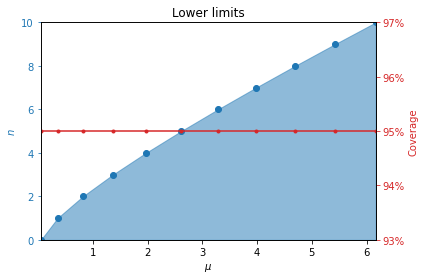

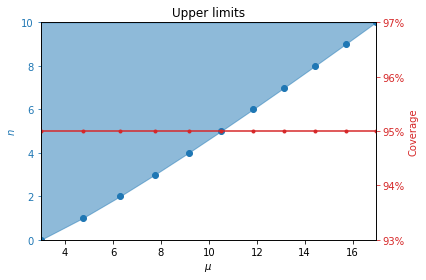

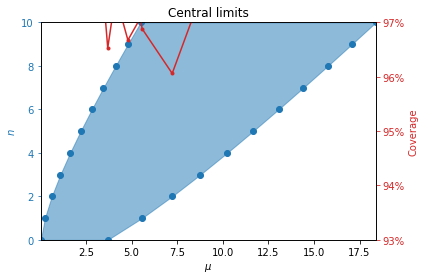

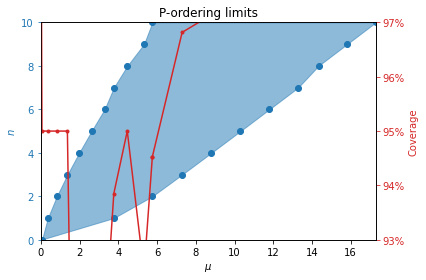

In [14]:
my_plot(n_values, l=lower_limits, title="Lower limits")
my_plot(n_values, u=upper_limits, title="Upper limits")
my_plot(n_values, l=[x for x, _ in central_limits],
        u=[x for _, x in central_limits], title="Central limits")
my_plot(n_values, l=[x for x, _ in p_limits], u=[x for _, x in np.nan_to_num(p_limits)],
        title="P-ordering limits")